In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [43]:
# Load pre-processed data
CL_CRC_BA = pd.read_csv("SingaporeCRC_data/CL_BA.csv", index_col=0,delimiter=",")
CL_CRC_BA = CL_CRC_BA.T

pid = CL_CRC_BA.index #.astype('float')
CL_CRC_BA.insert(0,'patient_id',pid)

CL_CRC_BA

,patient_id,g__Roseburia,g__Enterocloster,g__Blautia,g__Agathobacter,g__Lachnoclostridium,g__Coprococcus,g__Butyrivibrio,g__Lachnospira,g__Anaerostipes,...,g__Pseudoprevotella,g__Hoylesella,g__Aeromonas,g__Haemophilus,g__Leptotrichia,g__Treponema,g__Megamonas,g__Nocardioides,g__Petrimonas,g__Hymenobacter
X47,X47,1.630613,0.183694,1.048691,-0.103988,-0.286310,0.743310,-0.509453,-1.202600,-1.202600,...,1.048691,-0.797135,0.301477,-1.202600,4.982579,0.050162,-1.202600,0.502148,-1.895748,-0.509453
X95,X95,3.889290,3.756106,3.392034,2.982850,0.467386,0.082975,-1.031386,2.413297,1.457481,...,1.957178,-4.075908,-4.075908,-4.075908,-4.075908,-3.382761,2.993115,-2.977296,0.488440,0.568483
X106,X106,0.278136,2.215077,0.550070,-1.801306,0.395919,0.550070,-1.801306,-1.395841,-1.108158,...,2.100667,1.289737,-1.801306,-2.494453,-1.801306,-1.801306,-2.494453,-2.494453,-0.191868,-1.801306
X153,X153,0.969917,2.822977,2.356212,1.627973,-2.397378,1.851117,-2.397378,0.000517,0.821497,...,3.136011,3.107953,-1.011084,-2.397378,2.593054,-2.397378,-1.298766,-2.397378,0.860718,-1.704231
X326,X326,0.568649,5.213040,4.422658,-1.829246,0.310820,2.131567,0.310820,-0.730634,1.466591,...,-1.136099,-0.325168,-0.730634,4.895788,0.185657,-2.522393,6.470537,-2.522393,-2.522393,-0.124498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1662,X1662,5.667685,1.754647,3.414031,4.914790,0.045475,2.763234,-0.410001,-0.490044,0.797811,...,1.980877,0.045475,-1.029040,-2.058660,1.094076,-3.668097,4.726589,-4.361245,-3.668097,-3.262632
X1664,X1664,1.979841,1.979841,0.986589,0.629915,0.293442,1.775047,-1.315996,-1.315996,-0.217383,...,-1.315996,-1.315996,-1.315996,0.986589,-1.315996,-1.315996,0.293442,-0.622848,-1.315996,-0.622848
X1665,X1665,2.264600,1.971931,4.036258,4.899384,0.893121,1.971931,0.257132,0.257132,1.525643,...,-0.841480,-1.940092,-1.940092,5.129782,-1.246945,-1.246945,-1.246945,-1.940092,-1.940092,-1.940092
X1672,X1672,1.952678,3.039991,5.237636,-0.338733,1.638429,1.591176,0.103099,0.508564,1.541579,...,-2.535958,-1.842811,-1.149664,-0.744199,-0.744199,-2.535958,4.157366,-1.842811,-2.535958,-1.842811


In [44]:
metadata = pd.read_csv("SingaporeCRC_data/filtered_metadata.csv", index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata

,patient_id,TMB,KRAS,BRAF,NRAS,TP53,APC,PIK3CA,PIK3R1,SMAD4,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
3,X106,1028,wt,wt,wt,wt,wt,wt,wt,wt,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X153,80,mut,wt,wt,mut,mut,mut,wt,wt,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
5,X326,1512,mut,wt,wt,wt,wt,wt,wt,wt,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
7,X420,1976,mut,wt,wt,mut,mut,wt,wt,wt,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
8,X470,739,wt,wt,wt,wt,wt,wt,mut,mut,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,X1658,82,mut,wt,wt,mut,mut,wt,wt,wt,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
143,X1662,74,mut,wt,wt,mut,wt,wt,wt,wt,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
144,X1664,46,mut,wt,wt,mut,wt,wt,wt,wt,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
145,X1665,93,mut,wt,wt,mut,mut,wt,wt,wt,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [45]:
SG_CL_CRC_BA = pd.merge(CL_CRC_BA, metadata, on='patient_id', how='inner')
SG_CL_CRC_BA
#SG_CL_CRC_BA.to_csv('SingaporeCRC_data/SG_CL_CRC_BA', index=False)

In [35]:
class_counts = SG_CL_CRC_BA['MSI.Status'].value_counts()
print(class_counts)

MSI.Status
MSS    87
MSI    24
Name: count, dtype: int64


In [36]:
# Prepare features and target variable
X = SG_CL_CRC_BA.drop(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_CL_CRC_BA['MSI.Status']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['MSI' 'MSS']
Unique values of y: [0 1]
Shape of y: (111, 149)
Shape of y: (111,)


In [37]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X_scaled, y)

print(X_scaled.shape)
print(y.shape)


(174, 149)
(174,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Score: 0.8513333333333332
Test Set Accuracy: 0.9245283018867925


<Figure size 800x600 with 0 Axes>

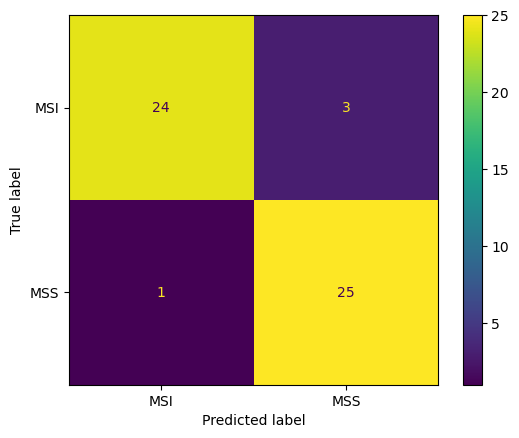

              precision    recall  f1-score   support

         MSI       0.96      0.89      0.92        27
         MSS       0.89      0.96      0.93        26

    accuracy                           0.92        53
   macro avg       0.93      0.93      0.92        53
weighted avg       0.93      0.92      0.92        53



In [38]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MSI', 'MSS'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['MSI', 'MSS'])
print(report)

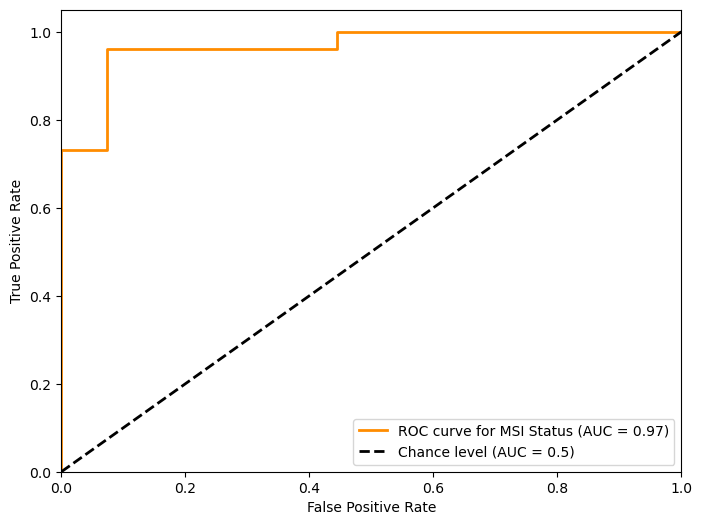

In [39]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for MSI Status (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_11992\2900214027.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


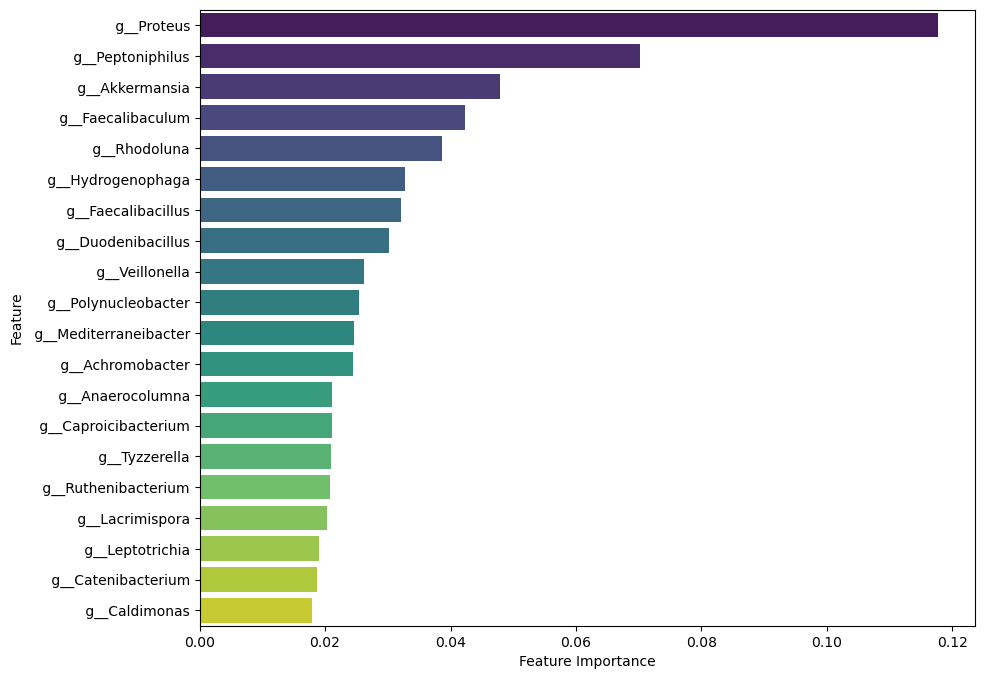

In [40]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

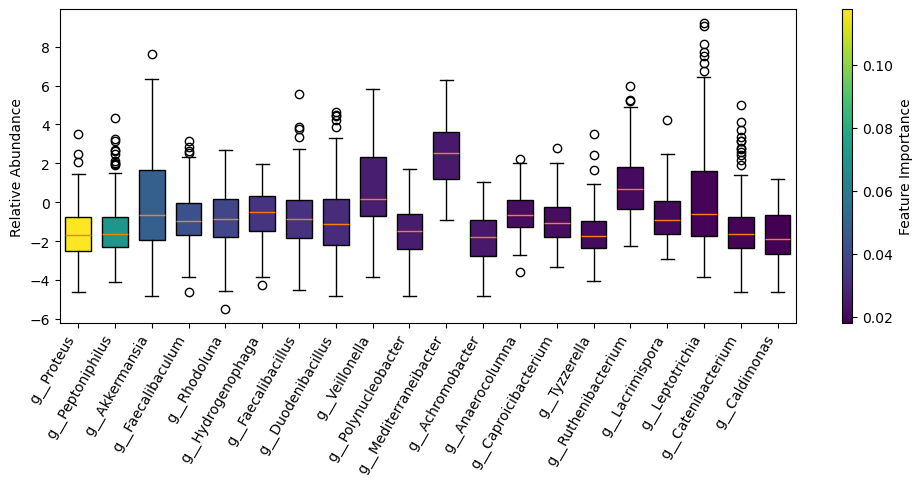

In [41]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

top_20_feature_names = feature_names[top_20_indices]

# Normalize feature importances
norm = Normalize(vmin=min(feature_importances[top_20_indices]), vmax=max(feature_importances[top_20_indices]))
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = [cmap(norm(importance)) for importance in feature_importances[top_20_indices]]

# Prepare data for boxplot
data = {}

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each box with the corresponding color based on feature importance
for i, (key, value) in enumerate(data.items()):
    box = ax.boxplot(value, positions=[i + 1], widths=0.7, patch_artist=True,
                     boxprops=dict(facecolor=colors[i], color='black'),
                     whiskerprops=dict(color='black'))

# Customize plot
ax.set_ylabel('Relative Abundance', fontsize=10)
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar, not for plotting
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label('Feature Importance', fontsize=10)

plt.show()